# Kickstarter project

In [0]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Preparation of data -> this was done offline, result is "test_joined.csv"

### Cleaning the kaggle dataset

Dataset 1: https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv

Dataset 2: https://webrobots.io/kickstarter-datasets/

In [0]:
def cleankaggle():
  data = []
  linecnt = 0
  with open("ks-projects-201801.csv", encoding='latin1') as f:
      for line in f.readlines():
          split_ = line.split(',')
          linecnt += 1
          if linecnt % 10000 == 0:
              print(linecnt)
          if len(split_) == 15:
              data.append(line)

  print("Added {} to output".format(len(data)))
  with open("test_newer.csv", 'w', encoding='latin1') as outf:
      outf.writelines(data)

### Cleaning and joining the webcrawler dataset

In [0]:
def cleanwebcrawler():
  import os
  from csv import reader, writer

  inputfolder = r"G:\Deep Learning"
  csv_filetemplate = "Kickstarter%03d.csv"
  first = True


  def clean_columns(split2):
      max_len = 37
      keep = [1, 16, 29, 30]
      temp = []
      for i in range(0, max_len):
          if i in keep:
              temp.append(split2[i])

      return temp


  for i in range(0, 51):
      linecnt = 0
      data = []
      fname = csv_filetemplate % i if i != 0 else "Kickstarter.csv"
      fname = inputfolder + os.sep + fname
      print("Opening and processing {}".format(fname))
      with open(fname, encoding='latin1') as f:
          csvreader = reader(f)
          for line in csvreader:
              if first:
                  split_ = line
                  print("First line: {}".format(split_))
                  split_ = clean_columns(split_)
                  print("Cleaned first line: {}".format(split_))
                  data.append(split_)
                  first = False
              else:
                  split_ = line
                  linecnt += 1
                  if linecnt % 1000 == 0:
                      print(linecnt)
                      print(len(split_))
                  if len(split_) == 37:
                      split_ = clean_columns(split_)
                      data.append(split_)
      print("Added {} to output from file {}".format(len(data), fname))
      with open("test_dataset2.csv", 'a', encoding='latin1', newline='') as outf:
          csvwriter = writer(outf)
          for row in data:
              csvwriter.writerow(row)

### Joining the two datasets on ID

In [0]:
def joinonids():
  from csv import reader, writer

  with open("test_newer.csv", encoding='latin1') as f:
      with open("test_dataset2.csv", encoding='latin1') as second:
          csvreader1 = reader(f)
          csvreader2 = reader(second)
          cache = dict()
          firstrow = None
          for row in csvreader1:
              if firstrow is None:
                  firstrow = row
              else:
                  cache[row[0]] = row

          print("Done caching IDs from first file.")
          output = list()
          for row in csvreader2:
              if firstrow is not None:
                  key = row.pop(1)
                  row.extend(firstrow)
                  output.append(row)
                  firstrow = None
              else:
                  if row[1] in cache.keys():
                      key = row.pop(1)
                      row.extend(cache[key])
                      del cache[key]
                      output.append(row)

  print("IDs found in test.csv = {}".format(len(cache) + len(output)))
  print("Matching IDs output = {}".format(len(output)))
  print("Writing out...")
  with open("test_joined.csv", 'w', encoding='latin1', newline='') as outf:
      csvwriter = writer(outf)
      for row in output:
          csvwriter.writerow(row)

## Github clone the dataset -> separate from normal github

In [7]:
!git clone https://github.com/Strongkong/cleaned_kickstarted_dataset

fatal: destination path 'cleaned_kickstarted_dataset' already exists and is not an empty directory.


In [0]:
folder = "./cleaned_kickstarted_dataset/"
filename = "test_joined.csv"
fullpath = folder + filename

## Load csv file

In [0]:
df = pd.read_csv(fullpath, encoding='utf-8', sep=',')

## Remove whitespaces from header names

In [0]:
df = df.rename(columns=lambda x: x.strip())


## Peak at head

In [11]:
print (df.blurb[3])

Für die Finanzierung der Veröffentlichung meiner Masterarbeit, die dann als eigenständiges Buch bei Turia&Kant erscheint.


In [12]:
df.head()

,blurb,spotlight,staff_pick,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,If you've ever been disheartened by how some p...,True,False,62545913,"""How We've Changed Jesus"" - Neal Samudre's Deb...",Nonfiction,Publishing,USD,2013-04-12,3500.0,2013-04-04 22:46:00,3651.0,successful,80,US,3651.00,3651.00,3500.00
1,This book will show you how to attract your id...,True,False,2031730466,Your Client Vision (Book) - How to sell withou...,Nonfiction,Publishing,GBP,2017-01-16,175.0,2016-12-18 20:09:14,271.0,successful,31,GB,94.80,332.73,214.86
2,I told my first lie when I was six and never s...,True,False,614137516,The Longest Lie I Ever Told,Nonfiction,Publishing,CAD,2016-11-08,3000.0,2016-10-09 18:32:56,3600.0,successful,74,CA,440.30,2668.45,2223.70
3,Für die Finanzierung der Veröffentlichung mein...,True,False,1164271753,Spurenlesen – Zur Philosophie der Human-Animal...,Nonfiction,Publishing,EUR,2016-08-14,1000.0,2016-07-15 14:17:36,1080.0,successful,12,DE,222.27,1223.21,1132.61
4,Six teens (age 13-15) are hiking VT's 272-mile...,True,False,384486589,Teens Hike VT's Long Trail and Write How-To an...,Nonfiction,Publishing,USD,2014-06-01,3700.0,2014-04-25 02:24:24,4051.2,successful,44,US,4051.20,4051.20,3700.00


## Main categorical features

### Categories

In [13]:
categories = df.category.unique()
print(categories)

['Nonfiction' 'Publishing' 'Mixed Media' 'Web' 'People' 'Comic Books'
 'Comedy' 'Punk' 'Technology' 'Theater' 'Jazz' 'Software' 'Anthologies'
 'Science Fiction' 'Illustration' 'Gadgets' 'Product Design' 'Farms'
 'Workshops' 'Footwear' 'Weaving' 'Sculpture' 'Experimental' 'Pet Fashion'
 'Art' 'Graphic Design' 'Civic Design' 'Tabletop Games' 'Calendars'
 'Design' 'Electronic Music' 'Installations' 'Family' 'Festivals'
 'Conceptual Art' 'Performance Art' 'Glass' 'Painting' 'Plays' 'Jewelry'
 'Letterpress' 'Public Art' 'Accessories' 'DIY' 'Small Batch'
 'Video Games' 'Fantasy' 'Music' 'Comics' 'Digital Art' 'Immersive'
 'Hardware' 'Radio & Podcasts' "Children's Books" 'Flight' 'Fine Art'
 'Musical' 'Rock' 'Apparel' 'Nature' 'Games' 'Crafts' 'Robots'
 'Stationery' 'DIY Electronics' 'Space Exploration' 'Apps'
 'Movie Theaters' 'Woodworking' 'Printing' 'Knitting' 'Crochet'
 'Camera Equipment' 'Wearables' 'Makerspaces' 'Pottery' 'Photography'
 'Fashion' 'Candles' 'Embroidery' 'Photobooks' 'Art

### Main categories

In [14]:
main_categories = df.main_category.unique()
print(main_categories)

['Publishing' 'Art' 'Journalism' 'Photography' 'Comics' 'Film & Video'
 'Music' 'Technology' 'Theater' 'Design' 'Food' 'Dance' 'Fashion' 'Crafts'
 'Games']


### Currencies

In [15]:
currencies = df.currency.unique()
print(currencies)

['USD' 'GBP' 'CAD' 'EUR' 'AUD' 'NZD' 'SEK' 'NOK' 'DKK' 'MXN' 'HKD' 'SGD'
 'CHF' 'JPY']


### States

In [16]:
states = df.state.unique()
print(states)

['successful' 'live' 'failed' 'canceled' 'suspended']


### Country

In [17]:
countries = df.country.unique()
print(countries)

['US' 'GB' 'CA' 'DE' 'AU' 'BE' 'FR' 'ES' 'NZ' 'SE' 'LU' 'NL' 'NO' 'AT'
 'DK' 'MX' 'IE' 'IT' 'HK' 'SG' 'CH' 'JP']


## Data visualization

### Categorical features

In [0]:
categorical_features = ['category', 'main_category', 'state', 'country', 'currency']
from copy import deepcopy
data = deepcopy(df)
n_items = len(data)

### COMMENTED OUT Only display common ones (source: laboratory 1)

Processing category. Unique count: 159.
['Nonfiction' 'Publishing' 'Mixed Media' 'Web' 'People' 'Comic Books'
 'Comedy' 'Punk' 'Technology' 'Theater' 'Jazz' 'Software' 'Anthologies'
 'Science Fiction' 'Illustration' 'Gadgets' 'Product Design' 'Farms'
 'Workshops' 'Footwear' 'Weaving' 'Sculpture' 'Experimental' 'Pet Fashion'
 'Art' 'Graphic Design' 'Civic Design' 'Tabletop Games' 'Calendars'
 'Design' 'Electronic Music' 'Installations' 'Family' 'Festivals'
 'Conceptual Art' 'Performance Art' 'Glass' 'Painting' 'Plays' 'Jewelry'
 'Letterpress' 'Public Art' 'Accessories' 'DIY' 'Small Batch'
 'Video Games' 'Fantasy' 'Music' 'Comics' 'Digital Art' 'Immersive'
 'Hardware' 'Radio & Podcasts' "Children's Books" 'Flight' 'Fine Art'
 'Musical' 'Rock' 'Apparel' 'Nature' 'Games' 'Crafts' 'Robots'
 'Stationery' 'DIY Electronics' 'Space Exploration' 'Apps'
 'Movie Theaters' 'Woodworking' 'Printing' 'Knitting' 'Crochet'
 'Camera Equipment' 'Wearables' 'Makerspaces' 'Pottery' 'Photography'
 'Fashion' 

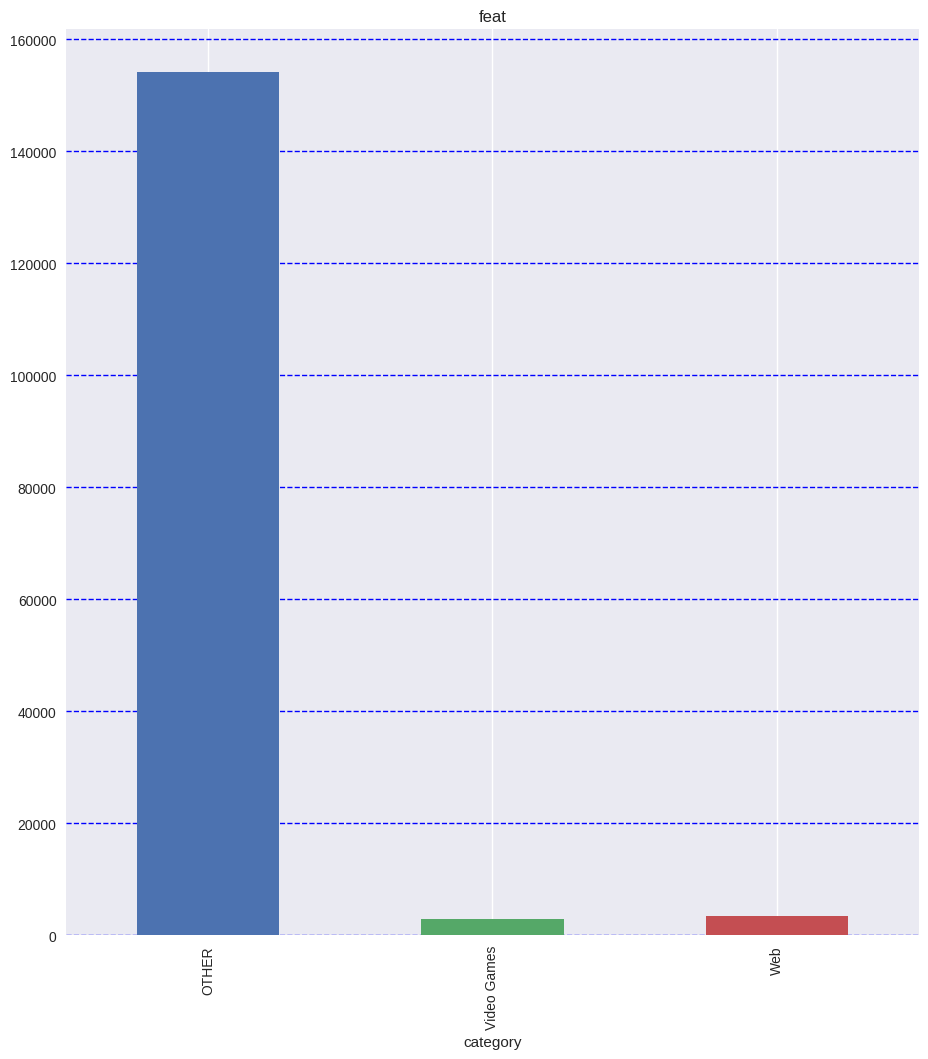

<class 'pandas.core.series.Series'>
Processing main_category. Unique count: 15.
['Publishing' 'Art' 'Journalism' 'Photography' 'Comics' 'Film & Video'
 'Music' 'Technology' 'Theater' 'Design' 'Food' 'Dance' 'Fashion' 'Crafts'
 'Games']


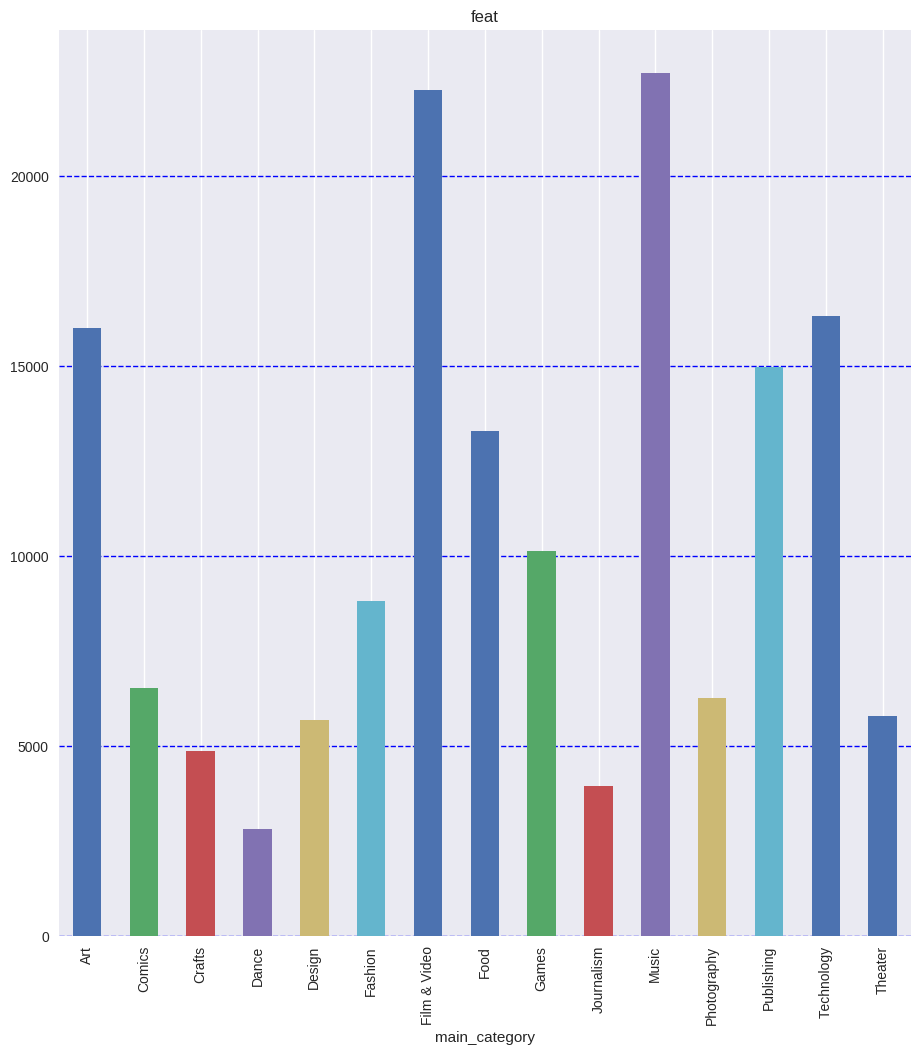

<class 'pandas.core.series.Series'>
Processing state. Unique count: 5.
['successful' 'live' 'failed' 'canceled' 'suspended']


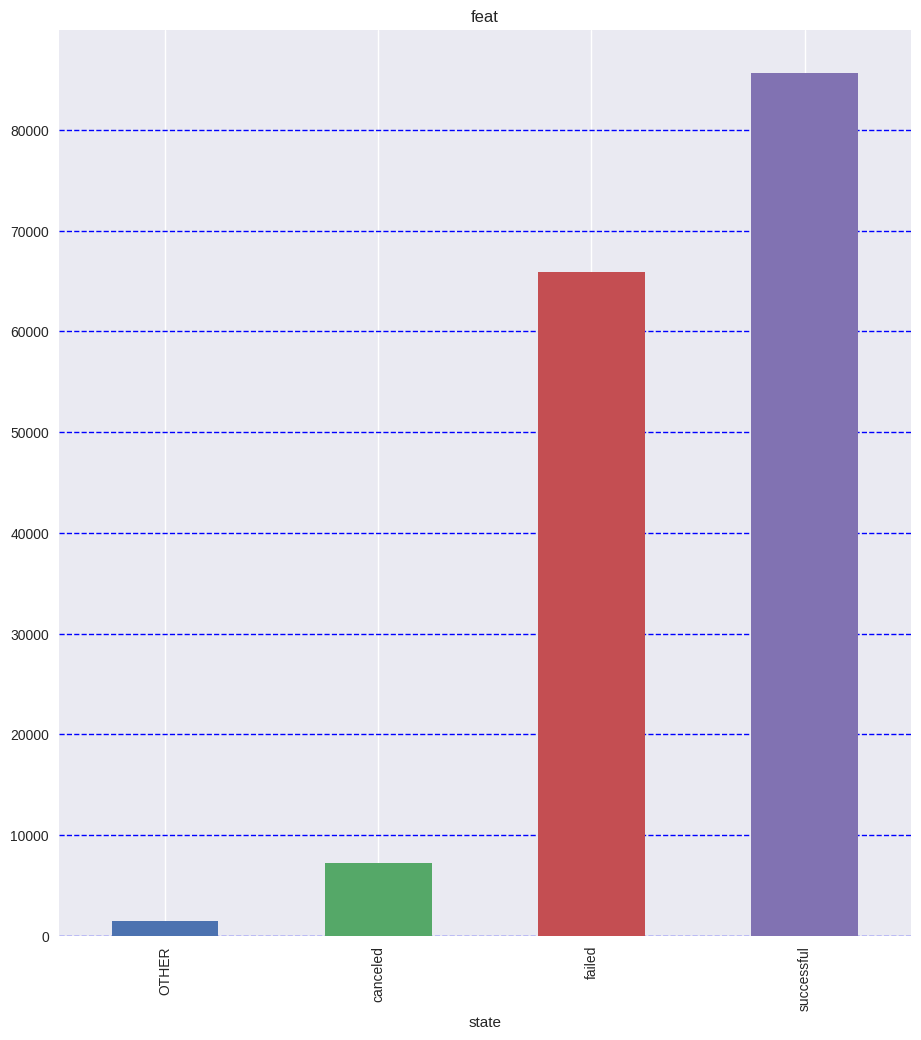

<class 'pandas.core.series.Series'>
Processing country. Unique count: 22.
['US' 'GB' 'CA' 'DE' 'AU' 'BE' 'FR' 'ES' 'NZ' 'SE' 'LU' 'NL' 'NO' 'AT'
 'DK' 'MX' 'IE' 'IT' 'HK' 'SG' 'CH' 'JP']


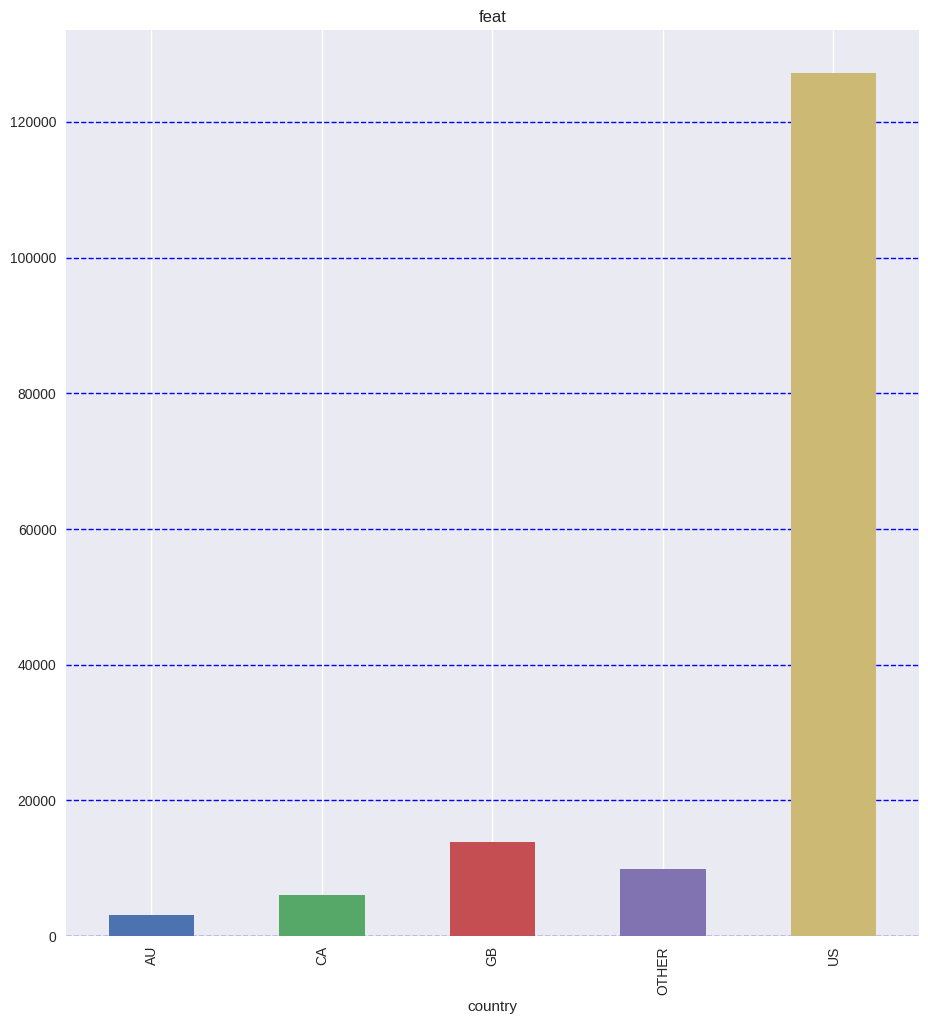

<class 'pandas.core.series.Series'>
Processing currency. Unique count: 14.
['USD' 'GBP' 'CAD' 'EUR' 'AUD' 'NZD' 'SEK' 'NOK' 'DKK' 'MXN' 'HKD' 'SGD'
 'CHF' 'JPY']


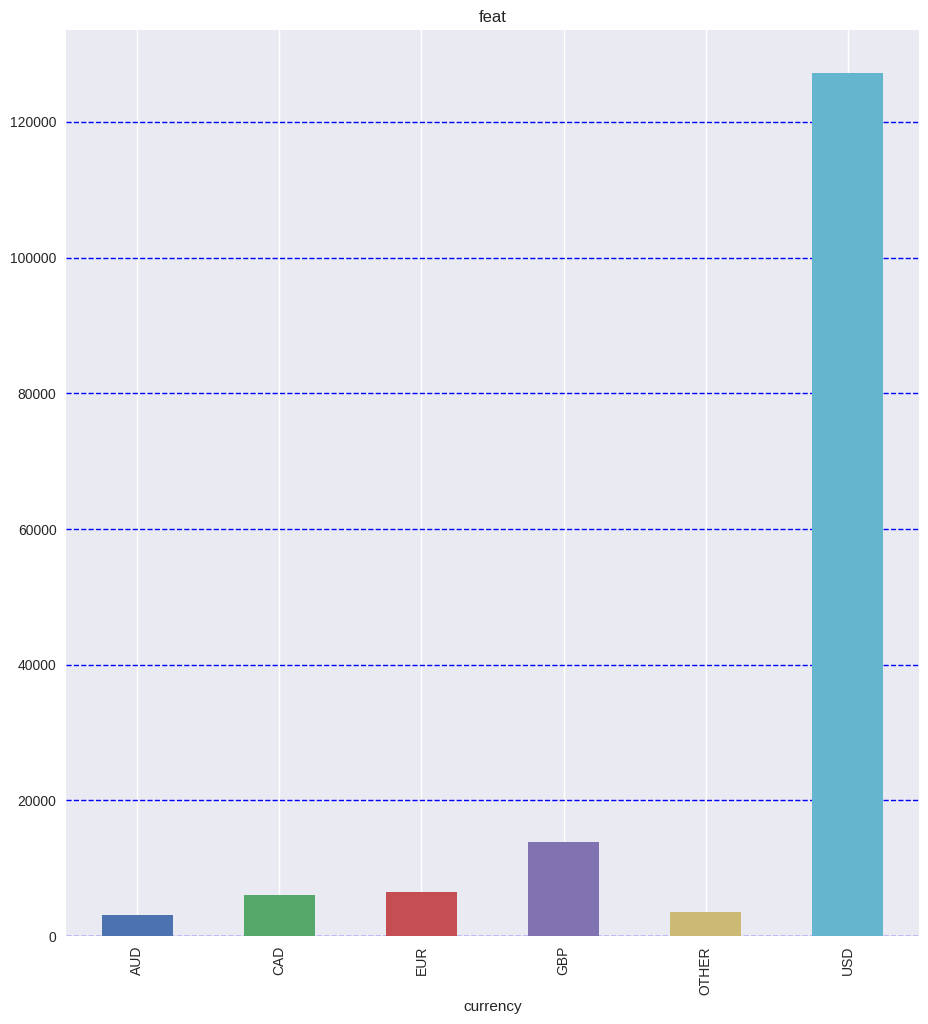

<class 'pandas.core.series.Series'>


In [19]:
index_ = 1

#plt.subplots_adjust(hspace=3.5)
for feat in categorical_features:
  fig = plt.figure(figsize=(11,12), dpi=100)
  ax = fig.add_subplot(1,1,1)
  plt.subplots_adjust(hspace=0.5)
  uniques = data[feat].nunique()
  print("Processing {}. Unique count: {}.".format(feat, uniques))
  if uniques < 160:
    print(data[feat].unique())
    for feat_value in data[feat].unique():
      if (len(data[data[feat]==feat_value])) / n_items < 0.015:
        # print("Adding {} category to OTHER...".format(feat_value))
        data[feat] = data[feat].apply(lambda x: "OTHER" if x==feat_value else x, 1)
  counts = data.groupby(feat).count()
  #plt.subplot(len(categorical_features), 1, index_)
  index_ += 1
  counts.iloc[:,0].plot(kind='bar', ax=ax, figsize=(11,12), title='feat', grid=True)
  plt.grid(b=True, which='major', color='b', linestyle='--', axis='y')
  plt.show()
  print(type(counts.iloc[:,0]))
#plt.show()

## Feature Engineering

### Remove "live" state as it represents non-finished data

In [0]:
df = df[(df['state'] != 'live')]

In [21]:
df.state.unique()

array(['successful', 'failed', 'canceled', 'suspended'], dtype=object)

### Encode labels -> has to be changed to OneHotEncoder

In [22]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.0)


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [24]:
categories_le = LabelEncoder()
categories_ohe = OneHotEncoder(sparse=False) # readable for humans

categories_led = categories_le.fit_transform(df.category)
categories_led = categories_led.reshape(-1, 1)

df_category = pd.DataFrame(categories_ohe.fit_transform(categories_led))
df_category = df_category.rename(columns=lambda x: 'category_' + str(x))
df = df.join(df_category)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [25]:
maincategories_le = LabelEncoder()
maincategories_ohe = OneHotEncoder(sparse=False) # readable for humans

maincategories_led = maincategories_le.fit_transform(df.main_category)
maincategories_led = maincategories_led.reshape(-1, 1)

df_main_category = pd.DataFrame(maincategories_ohe.fit_transform(maincategories_led))
df_main_category = df_main_category.rename(columns=lambda x: 'maincategory_' + str(x))
df = df.join(df_main_category)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [26]:
state_le = LabelEncoder()
state_ohe = OneHotEncoder(sparse=False) # readable for humans

state_led = state_le.fit_transform(df.state)
state_led = state_led.reshape(-1, 1)

df_state = pd.DataFrame(state_ohe.fit_transform(state_led))
df_state = df_state.rename(columns=lambda x: 'state_' + str(x))
df = df.join(df_state)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [27]:
country_le = LabelEncoder()
country_ohe = OneHotEncoder(sparse=False) # readable for humans

country_led = country_le.fit_transform(df.country)
country_led = country_led.reshape(-1, 1)

df_country = pd.DataFrame(country_ohe.fit_transform(country_led))
df_country = df_country.rename(columns=lambda x: 'country_' + str(x))
df = df.join(df_country)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [28]:
currency_le = LabelEncoder()
currency_ohe = OneHotEncoder(sparse=False) # readable for humans

currency_led = currency_le.fit_transform(df.currency)
currency_led = currency_led.reshape(-1, 1)

df_currency = pd.DataFrame(currency_ohe.fit_transform(currency_led))
df_currency = df_currency.rename(columns=lambda x: 'currency_' + str(x))
df = df.join(df_currency, rsuffix='_curr')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


categories_le = LabelEncoder()
df.category = categories_le.fit_transform(df.category)


maincategories_le = LabelEncoder()
df.main_category = maincategories_le.fit_transform(df.main_category)


state_le = LabelEncoder()
df.state = state_le.fit_transform(df.state)


country_le = LabelEncoder()
df.country = country_le.fit_transform(df.country)


currency_le = LabelEncoder()
df.currency = currency_le.fit_transform(df.currency)


### Change spotlight and staff pick to numeric values

In [0]:
df.spotlight = df.spotlight.astype(int)
df.staff_pick = df.staff_pick.astype(int)

### Drop ID, we dont need it anymore

In [0]:
df = df.drop('ID', axis=1)

In [31]:
df.head()

,blurb,spotlight,staff_pick,name,category,main_category,currency,deadline,goal,launched,...,currency_4,currency_5,currency_6,currency_7,currency_8,currency_9,currency_10,currency_11,currency_12,currency_13
0,If you've ever been disheartened by how some p...,1,0,"""How We've Changed Jesus"" - Neal Samudre's Deb...",Nonfiction,Publishing,USD,2013-04-12,3500.0,2013-04-04 22:46:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,This book will show you how to attract your id...,1,0,Your Client Vision (Book) - How to sell withou...,Nonfiction,Publishing,GBP,2017-01-16,175.0,2016-12-18 20:09:14,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,I told my first lie when I was six and never s...,1,0,The Longest Lie I Ever Told,Nonfiction,Publishing,CAD,2016-11-08,3000.0,2016-10-09 18:32:56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Für die Finanzierung der Veröffentlichung mein...,1,0,Spurenlesen – Zur Philosophie der Human-Animal...,Nonfiction,Publishing,EUR,2016-08-14,1000.0,2016-07-15 14:17:36,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Six teens (age 13-15) are hiking VT's 272-mile...,1,0,Teens Hike VT's Long Trail and Write How-To an...,Nonfiction,Publishing,USD,2014-06-01,3700.0,2014-04-25 02:24:24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Calculate length of funding

In [0]:
diff = (pd.to_datetime(df.deadline) - pd.to_datetime(df.launched)).map(lambda x: x.days)


In [33]:
print(diff.head())

0     7
1    28
2    29
3    29
4    36
dtype: int64


### Drop date times

In [0]:
df = df.drop(['deadline', 'launched'], axis=1)


### Add duration to the dataframe

In [0]:
df['duration'] = diff

In [36]:
df.head()

,blurb,spotlight,staff_pick,name,category,main_category,currency,goal,pledged,state,...,currency_5,currency_6,currency_7,currency_8,currency_9,currency_10,currency_11,currency_12,currency_13,duration
0,If you've ever been disheartened by how some p...,1,0,"""How We've Changed Jesus"" - Neal Samudre's Deb...",Nonfiction,Publishing,USD,3500.0,3651.0,successful,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7
1,This book will show you how to attract your id...,1,0,Your Client Vision (Book) - How to sell withou...,Nonfiction,Publishing,GBP,175.0,271.0,successful,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28
2,I told my first lie when I was six and never s...,1,0,The Longest Lie I Ever Told,Nonfiction,Publishing,CAD,3000.0,3600.0,successful,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
3,Für die Finanzierung der Veröffentlichung mein...,1,0,Spurenlesen – Zur Philosophie der Human-Animal...,Nonfiction,Publishing,EUR,1000.0,1080.0,successful,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
4,Six teens (age 13-15) are hiking VT's 272-mile...,1,0,Teens Hike VT's Long Trail and Write How-To an...,Nonfiction,Publishing,USD,3700.0,4051.2,successful,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,36


### Clean text, only keep whitespaces and letters

In [0]:
import re

In [38]:
regex = re.compile(r"[^\w\d ]", re.UNICODE | re.IGNORECASE)

name = df.name
blurb = df.blurb

name = name.map(lambda x: regex.sub(' ', str(x)).lower())
blurb = blurb.map(lambda x: regex.sub(' ', str(x)).lower())

print("names:")
print(name.head())
print("\nblurbs:")
print(blurb.head())

names:
0     how we ve changed jesus    neal samudre s deb...
1    your client vision  book    how to sell withou...
2                          the longest lie i ever told
3    spurenlesen   zur philosophie der human animal...
4    teens hike vt s long trail and write how to an...
Name: name, dtype: object

blurbs:
0    if you ve ever been disheartened by how some p...
1    this book will show you how to attract your id...
2    i told my first lie when i was six and never s...
3    für die finanzierung der veröffentlichung mein...
4    six teens  age 13 15  are hiking vt s 272 mile...
Name: blurb, dtype: object


In [39]:
name2 = name.apply(lambda x: x.split())
blurb2 = blurb.apply(lambda x: x.split())

print("names:")
print(name2.head())
print("\nblurbs:")
print(blurb2.head())

names:
0    [how, we, ve, changed, jesus, neal, samudre, s...
1    [your, client, vision, book, how, to, sell, wi...
2                   [the, longest, lie, i, ever, told]
3    [spurenlesen, zur, philosophie, der, human, an...
4    [teens, hike, vt, s, long, trail, and, write, ...
Name: name, dtype: object

blurbs:
0    [if, you, ve, ever, been, disheartened, by, ho...
1    [this, book, will, show, you, how, to, attract...
2    [i, told, my, first, lie, when, i, was, six, a...
3    [für, die, finanzierung, der, veröffentlichung...
4    [six, teens, age, 13, 15, are, hiking, vt, s, ...
Name: blurb, dtype: object


### Remove stop words -> might give better results

In [40]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stop_words = set(stopwords.words('english'))

In [42]:
name2 = name2.apply(lambda lista: [szo for szo in lista if szo not in stop_words] )
blurb2 = blurb2.apply(lambda lista: [szo for szo in lista if szo not in stop_words] )

print("names:")
print(name2.head(10))
print("\nblurbs:")
print(blurb2.head(10))

names:
0         [changed, jesus, neal, samudre, debut, book]
1       [client, vision, book, sell, without, selling]
2                           [longest, lie, ever, told]
3    [spurenlesen, zur, philosophie, der, human, an...
4    [teens, hike, vt, long, trail, write, guide, b...
5             [ako, ay, pilipino, coffee, table, book]
6                                        [truth, book]
7    [forks, three, years, five, continents, one, m...
8                                [mysterious, letters]
9          [motorcycle, adventures, farlap, max, book]
Name: name, dtype: object

blurbs:
0    [ever, disheartened, people, might, represent,...
1    [book, show, attract, ideal, client, get, buy,...
2    [told, first, lie, six, never, stopped, book, ...
3    [für, die, finanzierung, der, veröffentlichung...
4    [six, teens, age, 13, 15, hiking, vt, 272, mil...
5    [ako, ay, pilipino, noon, ngayon, creative, co...
6    [book, simple, action, resolved, life, long, q...
7    [around, world, ad

### Create bag of words
Using HashingVectorizer, because there are a lot of words

In [0]:
from sklearn.feature_extraction.text import HashingVectorizer

In [44]:
name_vectorizer = HashingVectorizer(n_features=2**8, lowercase=False, tokenizer = lambda doc: doc)
blurb_vectorizer = HashingVectorizer(n_features=2**8, lowercase=False, tokenizer = lambda doc: doc)

hashed_name = name_vectorizer.transform(name2)
hashed_blurb = blurb_vectorizer.transform(blurb2)

print("names:")
print(hashed_name.shape)
print(hashed_name[0])
print("\nblurbs:")
print(hashed_blurb.shape)
print(hashed_blurb[0])

names:
(159339, 256)
  (0, 14)	0.4082482904638631
  (0, 96)	-0.4082482904638631
  (0, 132)	-0.4082482904638631
  (0, 159)	-0.4082482904638631
  (0, 161)	-0.4082482904638631
  (0, 202)	0.4082482904638631

blurbs:
(159339, 256)
  (0, 4)	0.35355339059327373
  (0, 14)	0.35355339059327373
  (0, 25)	0.35355339059327373
  (0, 29)	0.35355339059327373
  (0, 103)	0.35355339059327373
  (0, 144)	0.35355339059327373
  (0, 157)	-0.35355339059327373
  (0, 166)	0.35355339059327373


In [45]:
print("names:")
print(hashed_name[0])
print("\nblurbs:")
print(hashed_blurb[0])

names:
  (0, 14)	0.4082482904638631
  (0, 96)	-0.4082482904638631
  (0, 132)	-0.4082482904638631
  (0, 159)	-0.4082482904638631
  (0, 161)	-0.4082482904638631
  (0, 202)	0.4082482904638631

blurbs:
  (0, 4)	0.35355339059327373
  (0, 14)	0.35355339059327373
  (0, 25)	0.35355339059327373
  (0, 29)	0.35355339059327373
  (0, 103)	0.35355339059327373
  (0, 144)	0.35355339059327373
  (0, 157)	-0.35355339059327373
  (0, 166)	0.35355339059327373


In [46]:
print(type(hashed_name))
print(type(hashed_blurb))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [47]:
print(hashed_name.todense().shape)
print(hashed_blurb.todense().shape)

(159339, 256)
(159339, 256)


### Create dataframe from scipy sparse matrix

In [48]:
df_hashed_name = pd.DataFrame(hashed_name.todense())
df_hashed_name = df_hashed_name.rename(columns=lambda x: 'name_' + str(x))
df_hashed_blurb = pd.DataFrame(hashed_blurb.todense())
df_hashed_blurb = df_hashed_blurb.rename(columns=lambda x: "blurb_" + str(x))

print("names:")
print(df_hashed_name.head())
print("\nblurbs:")
print(df_hashed_blurb.head())

names:
     name_0  name_1  name_2  name_3  name_4  name_5  name_6  name_7  name_8  \
0  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3 -0.377964     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4  0.000000     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   name_9    ...     name_246  name_247  name_248  name_249  name_250  \
0     0.0    ...          0.0       0.0       0.0       0.0       0.0   
1     0.0    ...          0.0       0.0       0.0       0.0       0.0   
2     0.0    ...          0.0       0.0       0.0       0.0       0.0   
3     0.0    ...          0.0       0.0       0.0       0.0       0.0   
4     0.0    ...          0.0       0.0       0.0       0.0       0.0   

   name_251  name_252  name_253  name_254  name_255  
0       0.0       0.0    

### Concat original matrix and hashed name matrix

In [0]:
df = df.join(df_hashed_name)
df = df.join(df_hashed_blurb)

In [50]:
print(df.shape)

(159339, 742)


### Dropping name column, name is stored now in bag

In [0]:
drop_columns = ['category', 'main_category', 'state', 'country', 'currency', 'goal', 'name', 'blurb']

df = df.drop(drop_columns, axis=1)

### Split into input and output

In [0]:
output_columns = ['backers', 'usd pledged']

X = df.drop(output_columns, axis=1)
Y = df[df.columns.intersection(output_columns)]

## Preparation for teaching

### Imports

In [53]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import copy
import pandas as pd
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
set_random_seed(123)
np.random.seed(123)

Using TensorFlow backend.


### Splitting into train test valid

In [54]:
test_split = 0.1
valid_split = 0.2

v_index = int(X.shape[0] * (1-valid_split-test_split))
t_index = int(X.shape[0] * (1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]

X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X_train = X[:v_index]
Y_train = Y[:v_index]

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


### Creating model

es = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

model = Sequential()
model.add(Dense(276, input_shape=(X_train.shape[1],)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(Y_train.shape[1], activation='linear'))

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)

history = model.fit(X_train, Y_train, epochs=100000, batch_size=256,
                    verbose=2, validation_data=(X_valid,Y_valid),
                   callbacks=[mcp, es])

from keras.models import load_model

model = load_model('weights.hdf5')

from sklearn.metrics import mean_squared_error
preds = model.predict(X_test)
err = mean_squared_error(Y_test, preds)

print("Error on test data: {}".format(err))

print(preds[0][:4])
print(type(preds))
print(type(Y_test))

print(preds.shape)
print(Y_test.shape)

pred_df = pd.DataFrame(data=preds)

pred_df.head()

Y_test.head()

Y_test.state = state_le.inverse_transform(Y_test.state)

pred_df[0]

pred_df[0] = pred_df[0].apply(lambda x: int(np.round(x)) if x >= 0 else 0)

pred_df

pred_df[0] = state_le.inverse_transform(pred_df[0])

print(pred_df.head())
print(Y_test.head())